# 测算股东人数 N天减少M%的情况，并评估其后走势带来的收益累积

In [505]:
import pymysql
import pandas as pd
import pandas.io.sql as sql
import numpy as np
import tushare as ts
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Step 1 获取原始信息

#### Step 1.1 获取股票代码

In [506]:
# 获取股票清单
basic = ts.get_stock_basics() #tushare的数据直接是DataFrame

#### step 1.2 从mysql 获取股东人数信息

In [507]:
# 存到 DF [renshu] 中
try:
    conn = pymysql.connect(host='localhost', port=3306, user='root', passwd='111111', db='STOCK', charset='utf8')
    renshu = sql.read_sql('select * from Xq_gdhs_20170802', conn) #将数据库读入dataframe
    conn.close()
except pymysql.Error as e:
    print('Mysql Error %d: %s' %(e.args[0], e.args[1]))

In [516]:
#renshu

### 以上：原始信息获取完毕

### Step 2 进行 数据格式 整理

#### Step 2.1 去除人[renshu]中无关列，仅剩下 [code] [date] [renshu]

In [509]:
renshu = renshu.drop('index',axis=1) #丢弃mysql中原有的index列

In [510]:
# 丢弃重复数据
renshu = renshu.drop_duplicates() 

# 丢弃不知道怎么出来的将近1000行NA
renshu = renshu.dropna(how='all')

# 修改为更简单的列名
renshu.rename(columns={'name_code':'code','gdhs':'renshu'},inplace=True)
#renshu.info()

In [511]:
renshu.head()

,code,date,renshu
0,600000,20170331,173130
1,600000,20161231,160501
2,600000,20160930,162071
3,600000,20160630,173951
4,600000,20160331,184005


#### step 2.2 清理basic列，仅剩 [code] [name] [timeToMarket]即可

In [512]:
basic = basic.drop(['holders','industry','area','pe','outstanding','totals','totalAssets',\
                    'liquidAssets','fixedAssets','reserved','reservedPerShare','esp','bvps',
                    'pb','undp','perundp','rev','profit','gpr','npr'],axis=1) #丢弃mysql中原有的index列

In [513]:
#将作为索引的code还原为列名，为了后面跟股东数据merge
basic = basic.reset_index(drop=False)
#basic.info()

#### step 2.3 将 人数 和 上市时间信息 合并，得到所有股票 所有时间点 股东户数表格

In [548]:
renshuall = pd.merge(renshu, basic, on='code')

In [549]:
renshuall.head()

,code,date,renshu,name,timeToMarket
0,600000,20170331,173130,浦发银行,19991110
1,600000,20161231,160501,浦发银行,19991110
2,600000,20160930,162071,浦发银行,19991110
3,600000,20160630,173951,浦发银行,19991110
4,600000,20160331,184005,浦发银行,19991110


### Step 3 整理 数据格式

In [550]:
# 处理有几行 timeToMarket == 0 的特殊情况
renshuall = renshuall[renshuall.timeToMarket != 0] # 排除未上市新股[timeToMarket为0]

In [551]:
# 将date 和 timeToMarket 格式变成 datetime，方便后续计算
renshuall.date = pd.to_datetime(renshuall.date,format='%Y%m%d')
renshuall.timeToMarket = pd.to_datetime(renshuall.timeToMarket,format='%Y%m%d')

renshuall

,code,date,renshu,name,timeToMarket
0,600000,2017-03-31,173130,浦发银行,1999-11-10
1,600000,2016-12-31,160501,浦发银行,1999-11-10
2,600000,2016-09-30,162071,浦发银行,1999-11-10
3,600000,2016-06-30,173951,浦发银行,1999-11-10
4,600000,2016-03-31,184005,浦发银行,1999-11-10
5,600000,2015-12-31,196015,浦发银行,1999-11-10
6,600000,2015-09-30,239254,浦发银行,1999-11-10
7,600000,2015-06-30,379582,浦发银行,1999-11-10
8,600000,2015-03-31,413279,浦发银行,1999-11-10
9,600000,2015-03-12,429994,浦发银行,1999-11-10


In [590]:
# 股东数 > 300人（未上市新股股东人数在 几十人）
renshuall = renshuall[renshuall['renshu']>300]

# 增加列 [daysToMarket]：计算股东数发布日期距离上市时间的天数（排除次新股）
renshuall['daysToMarket'] = renshuall.date - renshuall.timeToMarket
# 上市时间 > 90天，排除次新股
renshuall = renshuall[(renshuall.daysToMarket > timedelta(90))] 

In [591]:
renshuall

,code,date,renshu,name,timeToMarket,daysToMarket,pct,daygap
0,600000,2017-03-31,173130,浦发银行,1999-11-10,6351 days,0.078685,90 days
1,600000,2016-12-31,160501,浦发银行,1999-11-10,6261 days,-0.009687,92 days
2,600000,2016-09-30,162071,浦发银行,1999-11-10,6169 days,-0.068295,92 days
3,600000,2016-06-30,173951,浦发银行,1999-11-10,6077 days,-0.054640,91 days
4,600000,2016-03-31,184005,浦发银行,1999-11-10,5986 days,-0.061271,91 days
5,600000,2015-12-31,196015,浦发银行,1999-11-10,5895 days,-0.180724,92 days
6,600000,2015-09-30,239254,浦发银行,1999-11-10,5803 days,-0.369691,92 days
7,600000,2015-06-30,379582,浦发银行,1999-11-10,5711 days,-0.081536,91 days
8,600000,2015-03-31,413279,浦发银行,1999-11-10,5620 days,-0.038873,19 days
9,600000,2015-03-12,429994,浦发银行,1999-11-10,5601 days,0.158673,71 days


In [554]:
renshuall = renshuall.reset_index(drop=True)

In [555]:
# 增加列：相对上一期的变化率  &  较上一期的间隔时间
renshuall['pct'] = (renshuall['renshu'] - renshuall['renshu'].shift(-1)) / renshuall['renshu'].shift(-1)
renshuall['daygap'] = (renshuall['date'] - renshuall['date'].shift(-1))

# 将不同股票的 pct 和daygap设置为0 
n = 0
while n < len(renshuall)-1:
    #print(n)
    #print(renshuall.loc[n,'code'],renshuall.loc[n+1,'code'],renshuall.loc[n,'pct'])
    if renshuall.loc[n,'code'] != renshuall.loc[n+1,'code']:
        renshuall.at[n,'daygap'] = 0
        renshuall.at[n,'pct'] = 0
        n += 1
    else:
        n += 1
        continue

In [556]:
renshuall

,code,date,renshu,name,timeToMarket,daysToMarket,pct,daygap
0,600000,2017-03-31,173130,浦发银行,1999-11-10,6351 days,0.078685,90 days
1,600000,2016-12-31,160501,浦发银行,1999-11-10,6261 days,-0.009687,92 days
2,600000,2016-09-30,162071,浦发银行,1999-11-10,6169 days,-0.068295,92 days
3,600000,2016-06-30,173951,浦发银行,1999-11-10,6077 days,-0.054640,91 days
4,600000,2016-03-31,184005,浦发银行,1999-11-10,5986 days,-0.061271,91 days
5,600000,2015-12-31,196015,浦发银行,1999-11-10,5895 days,-0.180724,92 days
6,600000,2015-09-30,239254,浦发银行,1999-11-10,5803 days,-0.369691,92 days
7,600000,2015-06-30,379582,浦发银行,1999-11-10,5711 days,-0.081536,91 days
8,600000,2015-03-31,413279,浦发银行,1999-11-10,5620 days,-0.038873,19 days
9,600000,2015-03-12,429994,浦发银行,1999-11-10,5601 days,0.158673,71 days


### Step 4 数据筛选： N天内缩减 M%

In [1162]:
data = renshuall.copy()
condition3020 = 0
condition2013 = 1

#data

In [1163]:
data[data.name == '中潜股份']

,code,date,renshu,name,timeToMarket,daysToMarket,pct,daygap
65643,300526,2017-07-14,18513,中潜股份,2016-08-02,346 days,-0.176321,29 days
65644,300526,2017-06-15,22476,中潜股份,2016-08-02,317 days,0.102521,15 days
65645,300526,2017-05-31,20386,中潜股份,2016-08-02,302 days,0.447766,61 days
65646,300526,2017-03-31,14081,中潜股份,2016-08-02,241 days,-0.000781,31 days
65647,300526,2017-02-28,14092,中潜股份,2016-08-02,210 days,-0.000638,13 days
65648,300526,2017-02-15,14101,中潜股份,2016-08-02,197 days,-0.000425,15 days
65649,300526,2017-01-31,14107,中潜股份,2016-08-02,182 days,-0.000921,31 days
65650,300526,2016-12-31,14120,中潜股份,2016-08-02,151 days,0.000000,0 days


In [1164]:
if condition3020: ## 32天内缩减 20%
    data = data[(data.pct < -0.2) & (data.daygap < timedelta(32)) & (data.daygap > timedelta(0))]
elif condition2013: ## 20天内缩减 15% 
    data = data[(data.pct < -0.15) & (data.daygap < timedelta(20)) & (data.daygap > timedelta(0))]

### Step 5 获取筛选出来的股票 前 后 N个日历日的股价信息

In [1165]:
code = data.code
date = []
startlast = 20
endlast = 60
#初始化两个空DataFrame
priceafter = pd.DataFrame()
pricebefore = pd.DataFrame()
#code

In [1166]:
data.drop_duplicates(subset='name',keep='first',inplace=True)

In [1167]:
# 设置一个 信息公布前N日的开关，暂时不用
tag_bf = 1

In [1168]:
def formatDate(Date, formatType='YYYYMMDD'):
    #print('Inner Date == ',Date)
    formatType = formatType.replace('YYYY', Date[0:4])
    formatType = formatType.replace('MM', Date[5:7])
    formatType = formatType.replace('DD', Date[8:10])
    return formatType

In [1171]:
data = data.set_index('code')

KeyError: 'code'

In [1172]:
data

,date,renshu,name,timeToMarket,daysToMarket,pct,daygap
code,,,,,,,
600069,2015-03-31,61863,银鸽投资,1997-04-30,6544 days,-0.209590,15 days
600108,2015-04-17,191161,亚盛集团,1997-08-18,6451 days,-0.158826,17 days
600193,2015-04-16,32723,创兴资源,1999-05-27,5803 days,-0.157752,16 days
600329,2013-03-31,38901,中新药业,2001-06-06,4316 days,-0.226266,6 days
600391,2015-03-31,24058,航发科技,2001-12-12,4857 days,-0.156599,7 days
600789,2013-04-15,65536,鲁抗医药,1997-02-26,5892 days,-0.380386,15 days
600897,2015-04-17,24719,厦门空港,1996-05-31,6895 days,-0.155195,17 days
601233,2015-04-07,27563,桐昆股份,2011-05-18,1420 days,-0.166223,7 days
300013,2015-04-17,6862,新宁物流,2009-10-30,1995 days,-0.415303,17 days


In [1183]:
# 获取 data 选出的股票后30天的走势
for c in code:
    #print('AA ',c,'date=', date,'; Start =',start,'; end =  ', end)
    date = data.loc[c]['date']
    date2 = str(date)[0:10]
    
    enddate = date + timedelta(endlast)
    enddate = str(enddate)[0:10]
    #end = formatDate(str(end),'YYYYMMDD')
    
    
    startdate = date - timedelta(startlast)
    startdate = str(startdate)[0:10]
    #start = formatDate(str(start),'YYYYMMDD')
    #print('BB ',c,'date2=', date2,'; startdate =',startdate,'; end =',enddate)
    date = formatDate(str(date),'YYYYMMDD')
    
    #先获取数据日之后的行情，放入priceafter 
    p = ts.get_k_data(c, start=date2, end=enddate, autype='qfq')
    if tag_bf:
        q = ts.get_k_data(c, start=startdate, end=date2, autype='qfq')
    
    preturns = p['close'].pct_change()
    p['pct_change'] = (1 + preturns).cumprod() #逐行累积
    p = p.reset_index()
    
    if tag_bf:    
        qreturns = q['close'].pct_change()
        q['pct_change'] = (1 + qreturns).cumprod() #逐行累积
        q = q.reset_index()
    
    priceafter = priceafter.append(p)
    if tag_bf:
        pricebefore = pricebefore.append(q)

In [1186]:
#priceafter

In [1187]:
#pricebefore

In [1188]:
priceafter_copy = priceafter.copy()
if tag_bf:
    pricebefore_copy = pricebefore.copy()
priceafter_copy.head()

,index,date,open,close,high,low,volume,code,pct_change
0,55,2015-03-31,5.27,5.37,5.44,5.27,306791.0,600069,NaN
1,56,2015-04-01,5.37,5.42,5.45,5.35,241815.0,600069,1.009311
2,57,2015-04-02,5.43,5.57,5.69,5.43,314956.0,600069,1.037244
3,58,2015-04-03,5.55,5.63,5.71,5.55,251341.0,600069,1.048417
4,59,2015-04-07,5.63,5.64,5.65,5.54,373426.0,600069,1.050279


In [1025]:
priceafter_copy = priceafter_copy.drop(['index'],axis=1)
priceafter_copy = priceafter_copy.set_index('code')

pricebefore_copy = pricebefore_copy.drop(['index'],axis=1)
pricebefore_copy = pricebefore_copy.set_index('code')
#pricebefore_copy

In [1026]:
#去除重复行
if tag_bf:
    pricebefore_copy.drop_duplicates(inplace=True)
priceafter_copy.drop_duplicates(inplace=True)

In [1189]:
pricebefore_copy

,index,date,open,close,high,low,volume,code,pct_change
0,42,2015-03-11,5.380,5.270,5.440,5.210,269839.00,600069,NaN
1,43,2015-03-12,5.270,5.270,5.450,5.240,265145.00,600069,1.000000
2,44,2015-03-13,5.260,5.280,5.290,5.160,206406.00,600069,1.001898
3,45,2015-03-16,5.290,5.390,5.400,5.230,300014.00,600069,1.022770
4,46,2015-03-17,5.410,5.500,5.590,5.350,456640.00,600069,1.043643
5,47,2015-03-18,5.480,5.550,5.600,5.340,522557.00,600069,1.053131
6,48,2015-03-19,5.510,5.880,6.110,5.440,1048875.00,600069,1.115750
7,49,2015-03-20,5.750,5.730,5.860,5.680,628149.00,600069,1.087287
8,50,2015-03-24,5.440,5.440,5.440,5.440,173768.00,600069,1.032258
9,51,2015-03-25,5.400,5.470,5.570,5.220,725062.00,600069,1.037951


code
000513    Axes(0.125,0.125;0.775x0.755)
000625    Axes(0.125,0.125;0.775x0.755)
000651    Axes(0.125,0.125;0.775x0.755)
000797    Axes(0.125,0.125;0.775x0.755)
000821    Axes(0.125,0.125;0.775x0.755)
000852    Axes(0.125,0.125;0.775x0.755)
002035    Axes(0.125,0.125;0.775x0.755)
002048    Axes(0.125,0.125;0.775x0.755)
002081    Axes(0.125,0.125;0.775x0.755)
002098    Axes(0.125,0.125;0.775x0.755)
002110    Axes(0.125,0.125;0.775x0.755)
002170    Axes(0.125,0.125;0.775x0.755)
002189    Axes(0.125,0.125;0.775x0.755)
002216    Axes(0.125,0.125;0.775x0.755)
002345    Axes(0.125,0.125;0.775x0.755)
002359    Axes(0.125,0.125;0.775x0.755)
002366    Axes(0.125,0.125;0.775x0.755)
002430    Axes(0.125,0.125;0.775x0.755)
002460    Axes(0.125,0.125;0.775x0.755)
002466    Axes(0.125,0.125;0.775x0.755)
002589    Axes(0.125,0.125;0.775x0.755)
002606    Axes(0.125,0.125;0.775x0.755)
002629    Axes(0.125,0.125;0.775x0.755)
002676    Axes(0.125,0.125;0.775x0.755)
002753    Axes(0.125,0.125;0.775x0.

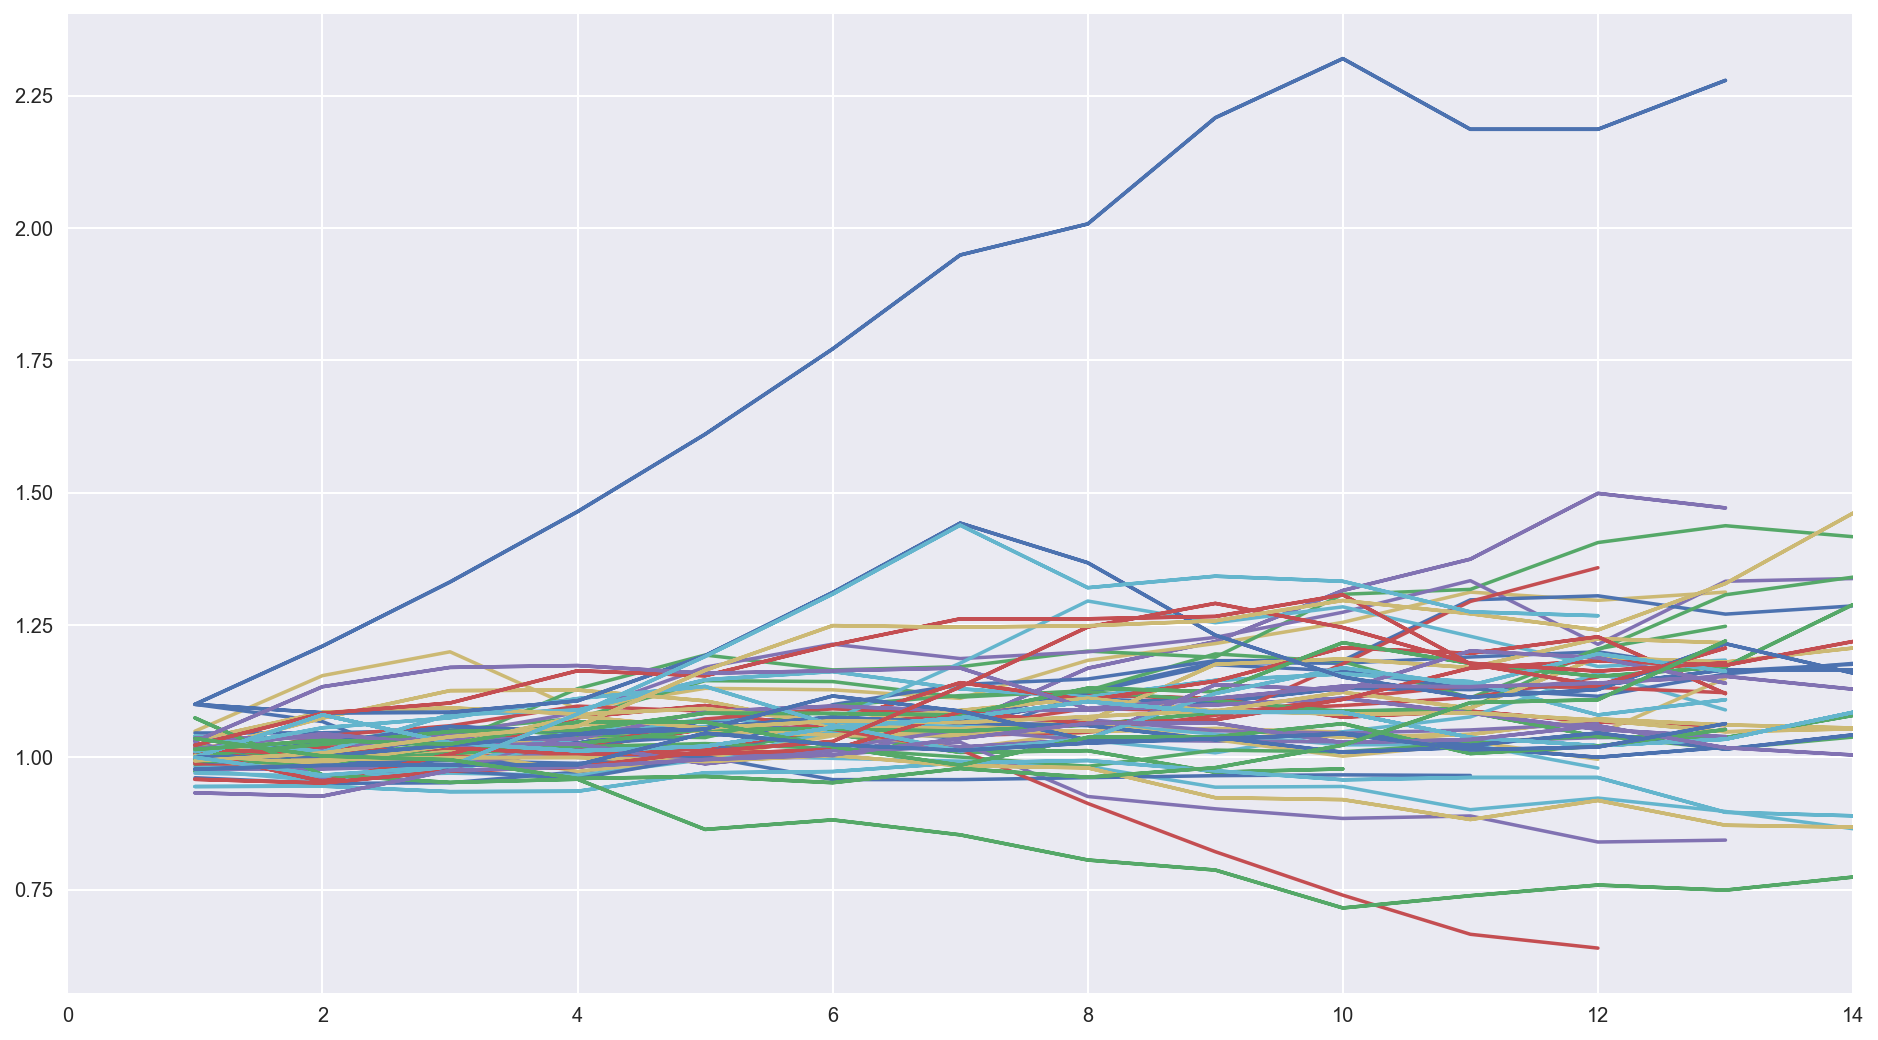

In [1190]:
pricebefore_copy.groupby(['code']).pct_change.plot(figsize=(16,9),grid=True)

In [1197]:
pricebefore_copy['pct_change2'] = pricebefore_copy['pct_change']
pricebefore_copy[pricebefore_copy.pct_change2 > 1.3]

,index,date,open,close,high,low,volume,code,pct_change,pct_change2
13,55,2015-03-30,38.084,40.222,40.501,38.084,227817.00,600391,1.328160,1.328160
14,56,2015-03-31,41.251,44.247,44.247,40.671,405895.00,600391,1.461069,1.461069
6,58,2013-04-03,5.416,5.416,5.416,5.317,442059.00,600789,1.308213,1.308213
7,59,2013-04-08,5.676,5.955,5.955,5.257,1151005.00,600789,1.438406,1.438406
8,60,2013-04-09,5.646,5.466,5.706,5.416,634219.00,600789,1.320290,1.320290
9,61,2013-04-10,5.446,5.556,5.716,5.446,599689.00,600789,1.342029,1.342029
10,62,2013-04-11,5.426,5.516,5.666,5.247,624929.00,600789,1.332367,1.332367
3,4,2015-04-01,10.545,10.545,10.545,10.545,1417.00,300018,1.331103,1.331103
4,5,2015-04-02,11.598,11.598,11.598,11.598,4210.00,300018,1.464024,1.464024
5,6,2015-04-03,12.756,12.756,12.756,12.756,17213.00,300018,1.610199,1.610199


In [ ]:
priceafter3['day_of_code'] = 0
n = 0
m = 1
while n < len(priceafter3)-1:
    #print(n,priceafter3.loc[n,'code'],priceafter3.loc[n+1,'code'])
    if priceafter3.loc[n,'code'] ==  priceafter3.loc[n+1,'code']:
        priceafter3.at[n,'day_of_code'] = m
        n += 1
        m += 1
    else:
        priceafter3.at[n,'day_of_code'] = m
        m = 1
        n += 1
        continue
priceafter3

In [1028]:
%config InlineBackend.figure_format = 'retina'

code
000513    Axes(0.125,0.125;0.775x0.755)
000625    Axes(0.125,0.125;0.775x0.755)
000651    Axes(0.125,0.125;0.775x0.755)
000797    Axes(0.125,0.125;0.775x0.755)
000821    Axes(0.125,0.125;0.775x0.755)
000852    Axes(0.125,0.125;0.775x0.755)
002035    Axes(0.125,0.125;0.775x0.755)
002048    Axes(0.125,0.125;0.775x0.755)
002081    Axes(0.125,0.125;0.775x0.755)
002098    Axes(0.125,0.125;0.775x0.755)
002110    Axes(0.125,0.125;0.775x0.755)
002170    Axes(0.125,0.125;0.775x0.755)
002189    Axes(0.125,0.125;0.775x0.755)
002216    Axes(0.125,0.125;0.775x0.755)
002345    Axes(0.125,0.125;0.775x0.755)
002359    Axes(0.125,0.125;0.775x0.755)
002366    Axes(0.125,0.125;0.775x0.755)
002430    Axes(0.125,0.125;0.775x0.755)
002460    Axes(0.125,0.125;0.775x0.755)
002466    Axes(0.125,0.125;0.775x0.755)
002589    Axes(0.125,0.125;0.775x0.755)
002606    Axes(0.125,0.125;0.775x0.755)
002629    Axes(0.125,0.125;0.775x0.755)
002676    Axes(0.125,0.125;0.775x0.755)
002753    Axes(0.125,0.125;0.775x0.

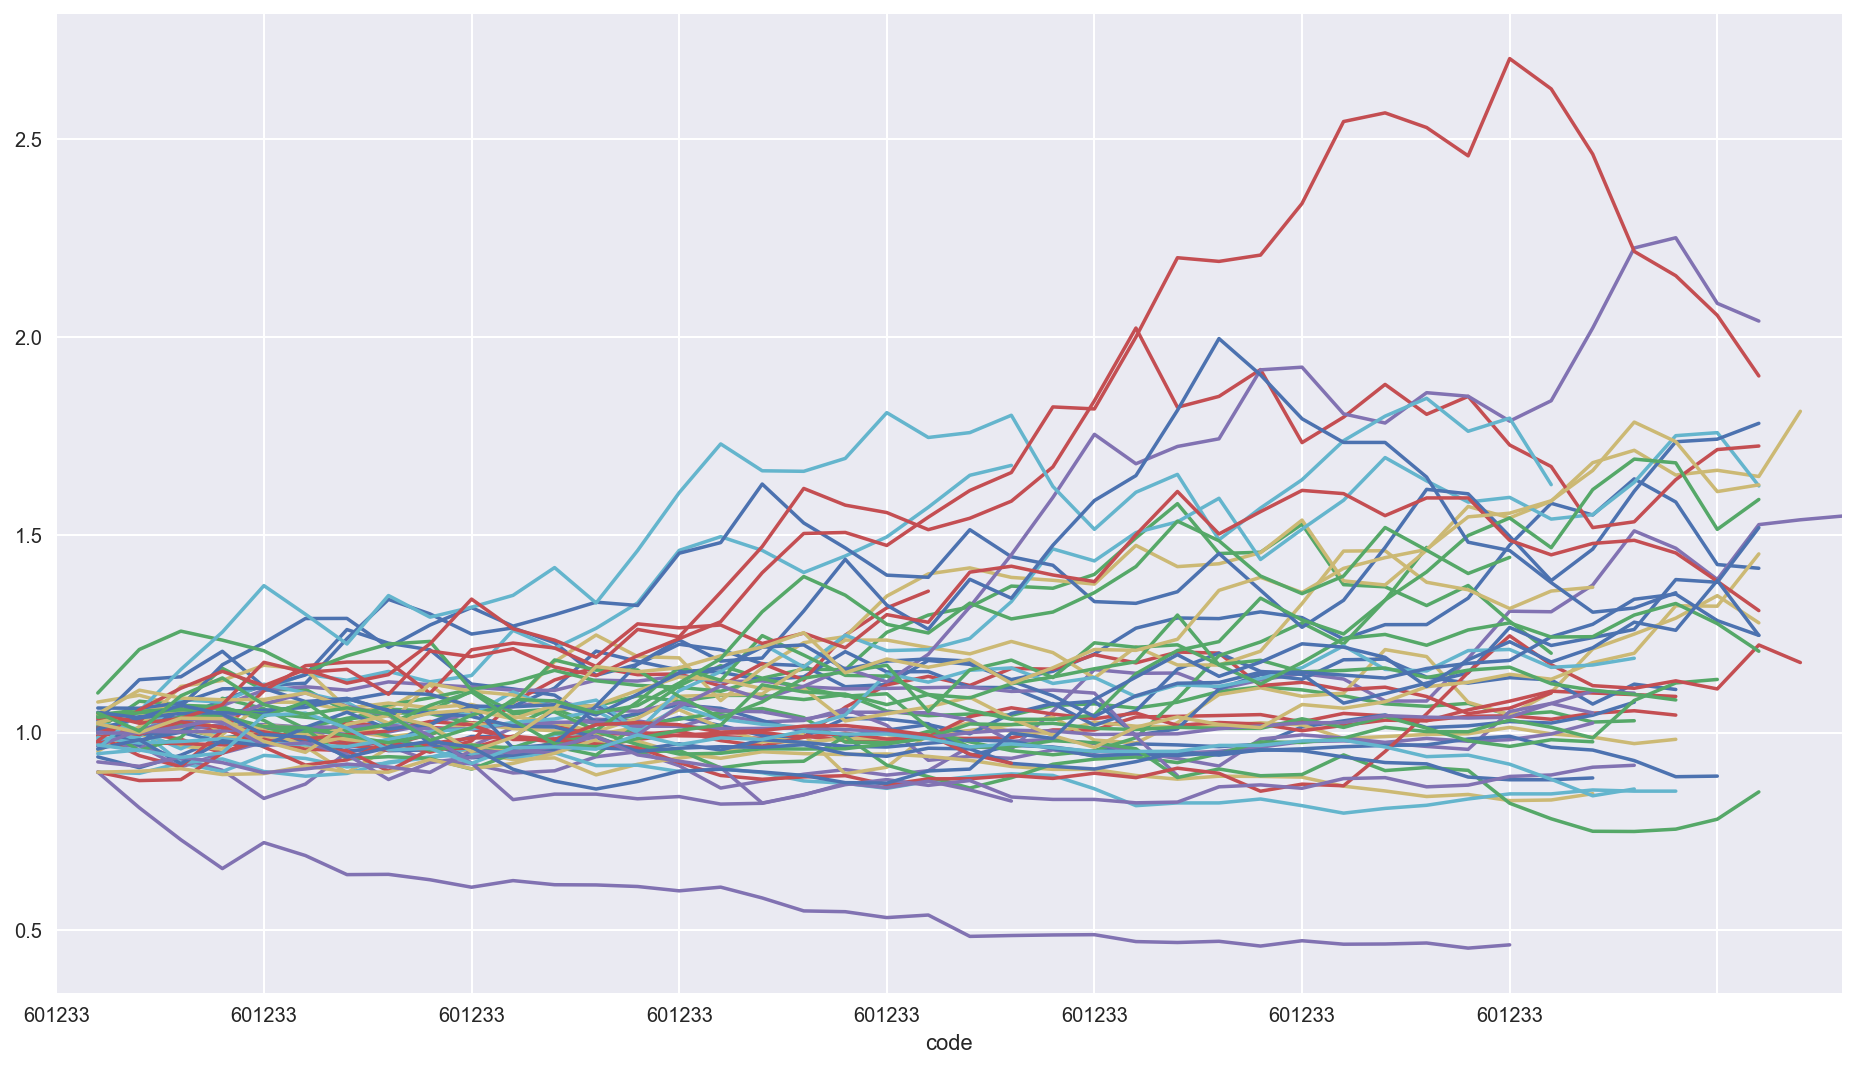

In [1029]:
priceafter_copy.groupby(['code']).pct_change.plot(figsize=(16,9),grid=True)

In [1030]:
demo_data = priceafter_copy.groupby(['code']).pct_change.describe()
demo_data

,count,mean,std,min,25%,50%,75%,max
code,,,,,,,,
000513,41.0,1.255108,0.149509,1.036848,1.154933,1.236345,1.300012,1.641379
000625,38.0,1.055259,0.034674,0.976421,1.031567,1.058175,1.078559,1.115469
000651,39.0,1.012398,0.024961,0.977795,0.988728,1.006780,1.040258,1.055259
000797,43.0,1.080462,0.213727,0.833607,0.911440,0.967348,1.154882,1.547256
000821,41.0,1.043736,0.116263,0.893155,0.960800,1.019842,1.096037,1.346185
000852,13.0,0.937799,0.033825,0.897002,0.913144,0.934666,0.961568,1.000000
002035,38.0,0.997023,0.039438,0.911293,0.968169,0.991712,1.026958,1.076867
002048,36.0,1.227032,0.163331,1.020020,1.066892,1.165827,1.368966,1.578694
002081,36.0,1.059952,0.078264,0.948414,0.994551,1.036559,1.119540,1.203621


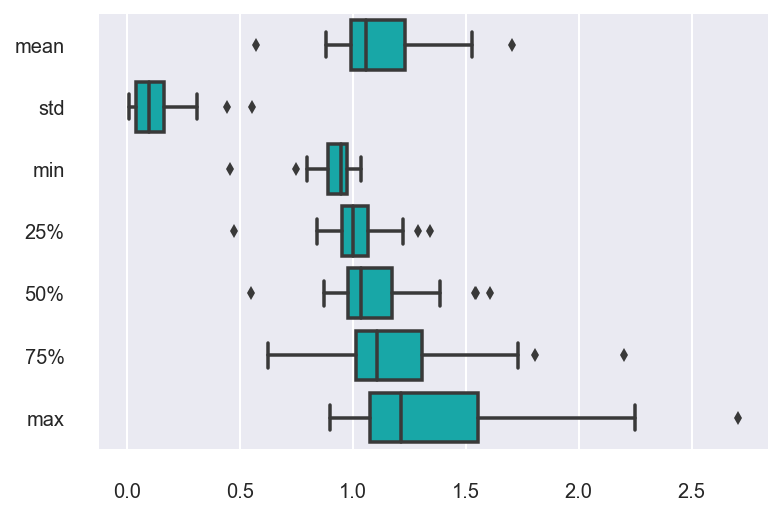

In [1031]:
import seaborn as sns
demo_data = demo_data.loc[:,demo_data.columns[1:]]
#sns.boxplot(data=demo_data,orient="h",color="c")
sns.boxplot(data=demo_data,orient="h",color="c")
sns.despine(trim=True,offset=10)

In [1032]:
priceafter3 = priceafter_copy.reset_index()

In [1033]:
priceafter3['day_of_code'] = 0
n = 0
m = 1
while n < len(priceafter3)-1:
    #print(n,priceafter3.loc[n,'code'],priceafter3.loc[n+1,'code'])
    if priceafter3.loc[n,'code'] ==  priceafter3.loc[n+1,'code']:
        priceafter3.at[n,'day_of_code'] = m
        n += 1
        m += 1
    else:
        priceafter3.at[n,'day_of_code'] = m
        m = 1
        n += 1
        continue
priceafter3

,code,date,open,close,high,low,volume,pct_change,day_of_code
0,600069,2015-03-31,5.27,5.37,5.44,5.27,306791.0,NaN,1
1,600069,2015-04-01,5.37,5.42,5.45,5.35,241815.0,1.009311,2
2,600069,2015-04-02,5.43,5.57,5.69,5.43,314956.0,1.037244,3
3,600069,2015-04-03,5.55,5.63,5.71,5.55,251341.0,1.048417,4
4,600069,2015-04-07,5.63,5.64,5.65,5.54,373426.0,1.050279,5
5,600069,2015-04-08,5.66,5.62,5.75,5.51,370329.0,1.046555,6
6,600069,2015-04-09,5.75,5.76,5.85,5.53,431803.0,1.072626,7
7,600069,2015-04-10,5.75,5.81,5.84,5.71,308748.0,1.081937,8
8,600069,2015-04-13,6.06,5.91,6.06,5.90,383471.0,1.100559,9
9,600069,2015-04-14,5.92,5.89,5.97,5.84,293094.0,1.096834,10


In [1042]:
#priceafter3.day_of_code.sort_values()

2010     0
989      1
965      1
923      1
883      1
843      1
806      1
792      1
750      1
726      1
684      1
646      1
607      1
565      1
526      1
484      1
446      1
404      1
362      1
324      1
288      1
246      1
207      1
165      1
1002     1
1047     1
1086     1
1126     1
1975     1
1932     1
        ..
605     41
1972    41
40      41
963     41
1930    41
286     41
524     41
606     42
41      42
1482    42
525     42
1211    42
725     42
403     42
1973    42
1845    42
445     42
125     42
206     42
1167    42
791     42
1046    42
964     42
287     42
83      42
1931    42
1168    43
1974    43
1846    43
1169    44
Name: day_of_code, Length: 2011, dtype: int64

In [1128]:
# 看 10天之后的涨跌幅结果
d03 = priceafter3[priceafter3.day_of_code == 3].reset_index()
d05 = priceafter3[priceafter3.day_of_code == 5].reset_index()
d10 = priceafter3[priceafter3.day_of_code == 10].reset_index()
d15 = priceafter3[priceafter3.day_of_code == 15].reset_index()
d18 = priceafter3[priceafter3.day_of_code == 18].reset_index()
d20 = priceafter3[priceafter3.day_of_code == 20].reset_index()
d22 = priceafter3[priceafter3.day_of_code == 22].reset_index()
d25 = priceafter3[priceafter3.day_of_code == 25].reset_index()
d30 = priceafter3[priceafter3.day_of_code == 30].reset_index()
#d10

In [1157]:
endprice = pd.DataFrame({"d03": d03["pct_change"],
                         "d05": d05["pct_change"],
                         "d10": d10["pct_change"],
                         "d15": d15["pct_change"],
                         "d18": d18["pct_change"],
                         "d20": d20["pct_change"],
                         "d22": d15["pct_change"],
                         "d25": d25["pct_change"],
                         "d30": d30["pct_change"]
                        })
#endprice

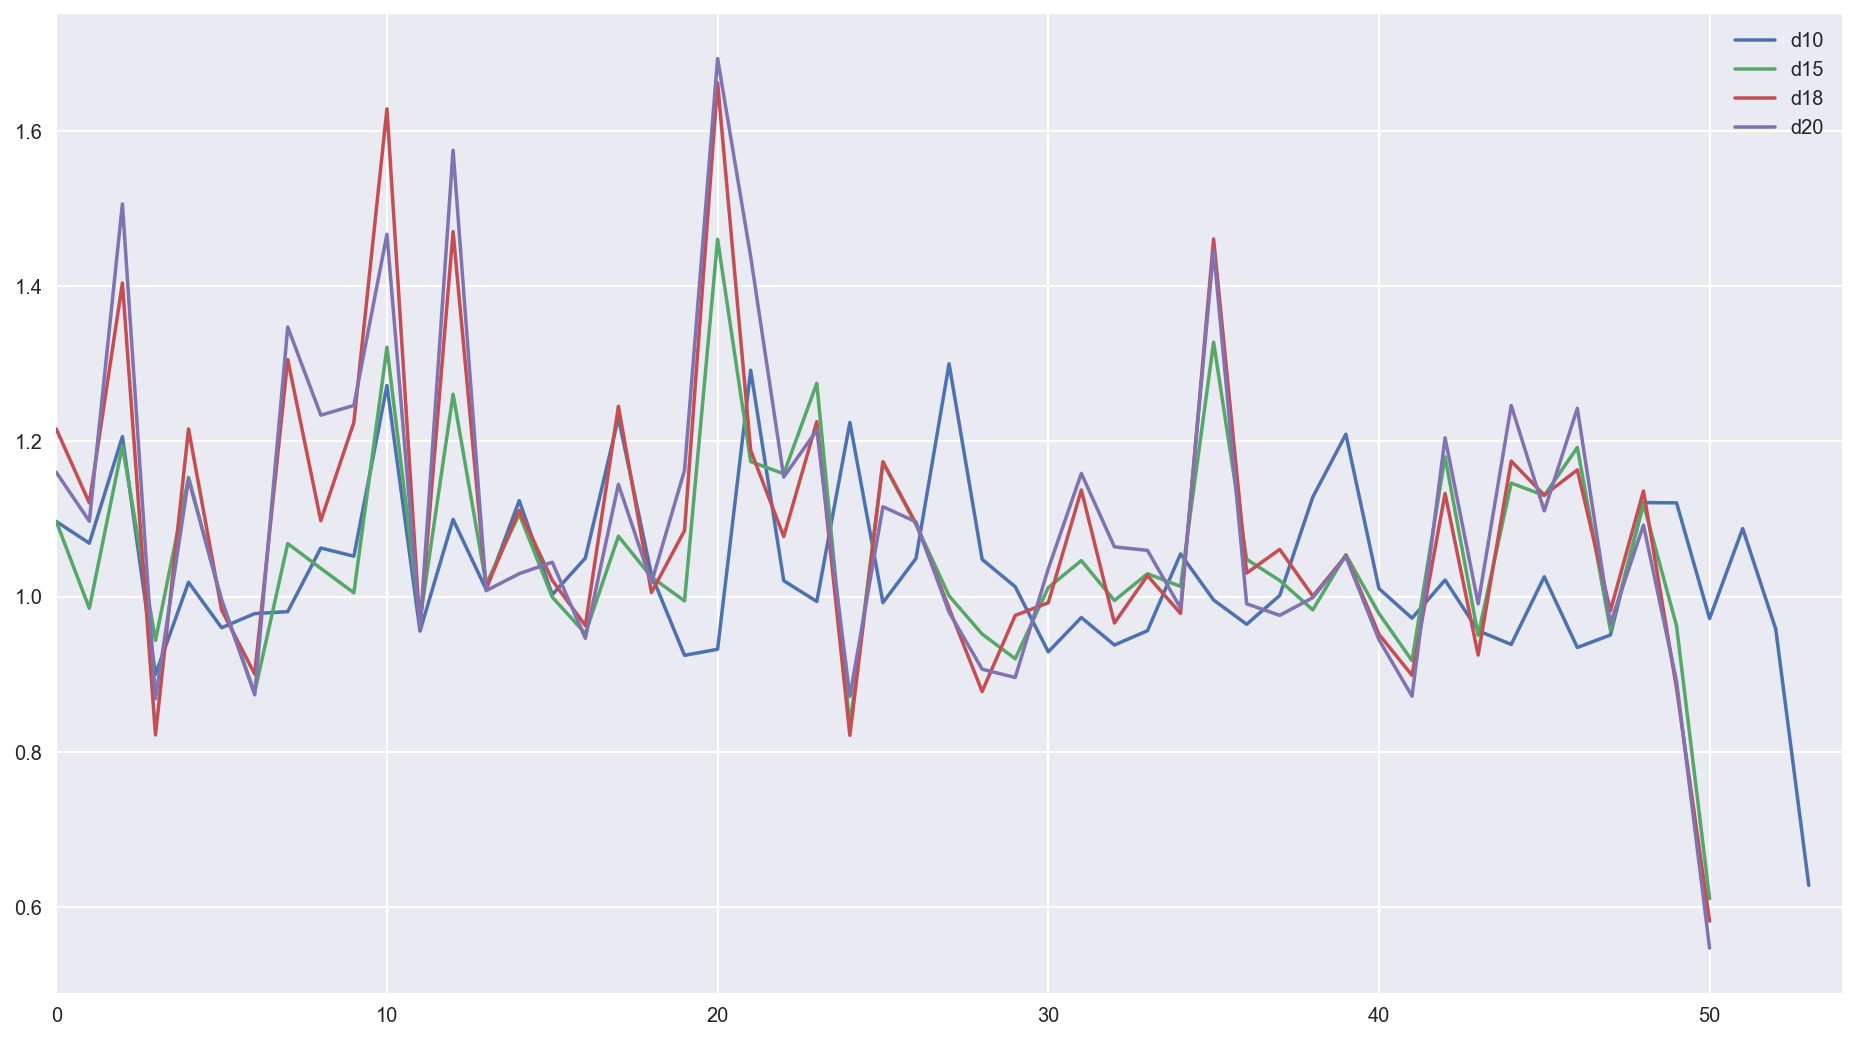

In [1158]:
pd.DataFrame(endprice[['d10','d15','d18','d20']]).plot(figsize=(16,9),grid=True)

In [1159]:
endprice.describe()

,d03,d05,d10,d15,d18,d20,d22,d25,d30
count,55.000000,54.000000,54.000000,51.000000,51.000000,51.000000,51.000000,47.000000,46.000000
mean,1.002883,1.028128,1.032066,1.054719,1.088922,1.099506,1.054719,1.123250,1.193493
std,0.063884,0.095873,0.113917,0.138318,0.196862,0.206861,0.138318,0.249821,0.327932
min,0.810072,0.656295,0.628058,0.610971,0.582014,0.547302,0.610971,0.488489,0.460432
25%,0.973948,0.980771,0.961087,0.980672,0.977070,0.978000,0.980672,0.971553,0.978269
50%,1.000000,1.025934,1.011620,1.025218,1.060893,1.059616,1.025218,1.054264,1.127802
75%,1.039404,1.070171,1.083013,1.138316,1.174241,1.183675,1.138316,1.183040,1.354927
max,1.210135,1.254132,1.300012,1.460359,1.661796,1.693054,1.460359,1.823232,2.207071


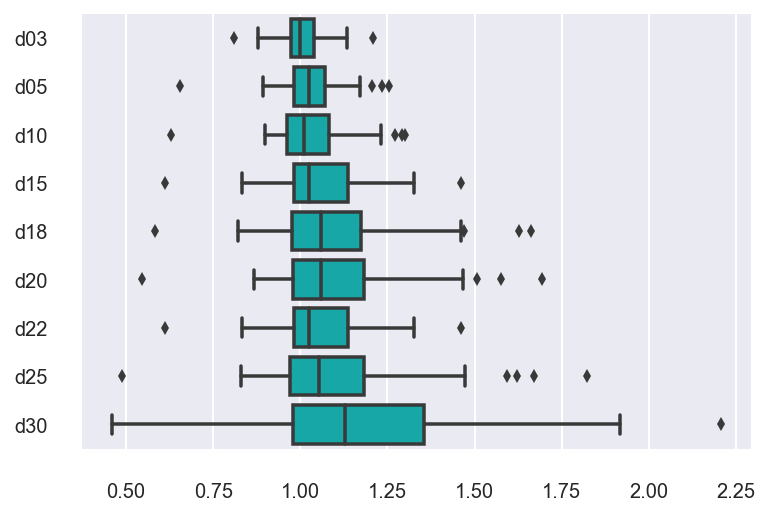

In [1160]:
sns.boxplot(data=endprice,orient="h",color="c")
sns.despine(trim=True,offset=10)

# 以下部分未完成
#### 尝试设置止损线，看是否会提高盈利率

In [1118]:
priceafter4 = priceafter3.copy()
priceafter4.head()

,code,date,open,close,high,low,volume,pct_change,day_of_code
0,600069,2015-03-31,5.27,5.37,5.44,5.27,306791.0,NaN,1
1,600069,2015-04-01,5.37,5.42,5.45,5.35,241815.0,1.009311,2
2,600069,2015-04-02,5.43,5.57,5.69,5.43,314956.0,1.037244,3
3,600069,2015-04-03,5.55,5.63,5.71,5.55,251341.0,1.048417,4
4,600069,2015-04-07,5.63,5.64,5.65,5.54,373426.0,1.050279,5


In [1119]:
priceafter4 = priceafter4.dropna(how='any')
priceafter4['pct_change2'] = priceafter4['pct_change']
priceafter4

,code,date,open,close,high,low,volume,pct_change,day_of_code,pct_change2
1,600069,2015-04-01,5.37,5.42,5.45,5.35,241815.0,1.009311,2,1.009311
2,600069,2015-04-02,5.43,5.57,5.69,5.43,314956.0,1.037244,3,1.037244
3,600069,2015-04-03,5.55,5.63,5.71,5.55,251341.0,1.048417,4,1.048417
4,600069,2015-04-07,5.63,5.64,5.65,5.54,373426.0,1.050279,5,1.050279
5,600069,2015-04-08,5.66,5.62,5.75,5.51,370329.0,1.046555,6,1.046555
6,600069,2015-04-09,5.75,5.76,5.85,5.53,431803.0,1.072626,7,1.072626
7,600069,2015-04-10,5.75,5.81,5.84,5.71,308748.0,1.081937,8,1.081937
8,600069,2015-04-13,6.06,5.91,6.06,5.90,383471.0,1.100559,9,1.100559
9,600069,2015-04-14,5.92,5.89,5.97,5.84,293094.0,1.096834,10,1.096834
10,600069,2015-04-15,5.89,5.73,6.05,5.72,281206.0,1.067039,11,1.067039


In [1116]:
priceafter4[priceafter4.pct_change2 > 0.95]

,code,date,open,close,high,low,volume,pct_change,day_of_code,pct_change2
1,600069,2015-04-01,5.370,5.420,5.450,5.350,241815.0,1.009311,2,1.009311
2,600069,2015-04-02,5.430,5.570,5.690,5.430,314956.0,1.037244,3,1.037244
3,600069,2015-04-03,5.550,5.630,5.710,5.550,251341.0,1.048417,4,1.048417
4,600069,2015-04-07,5.630,5.640,5.650,5.540,373426.0,1.050279,5,1.050279
5,600069,2015-04-08,5.660,5.620,5.750,5.510,370329.0,1.046555,6,1.046555
6,600069,2015-04-09,5.750,5.760,5.850,5.530,431803.0,1.072626,7,1.072626
7,600069,2015-04-10,5.750,5.810,5.840,5.710,308748.0,1.081937,8,1.081937
8,600069,2015-04-13,6.060,5.910,6.060,5.900,383471.0,1.100559,9,1.100559
9,600069,2015-04-14,5.920,5.890,5.970,5.840,293094.0,1.096834,10,1.096834
10,600069,2015-04-15,5.890,5.730,6.050,5.720,281206.0,1.067039,11,1.067039


In [ ]:
priceafter4 = priceafter4[priceafter4.pct_change > 0.95]